# Simulate SimSAX parameters

SimSAX (Similarity-based on Symbolic Aggregate approXimation) is a similarity measure between defect-inflow profiles.

In this notebook, we show how to use simulation to tune the measure parameters.

In [1]:
%reload_ext autoreload
%autoreload

# external imports
import string
import pandas as pd
import numpy as np
import random
import itertools
import matplotlib.pyplot as plt
%matplotlib inline

# simsax
from simsax.projects import load_backlog
from simsax.alignment.model import ProjectSequence
from simsax.alignment.finders import calculate_project_alignment, create_sax_signature, find_motifs
from simsax.alignment.calculators import AlignmentsCoverageCalculator
from simsax.alignment.plot import plot_all_motif_alignments, plot_subplot_motif, plot_comparisons_motif, plot_sequence_with_anomalies
from simsax.alignment.simulation import simulate_alignments, plot_simulation_word_vs_w_to_n, plot_simulation_3d

from sax.pysax import SAXModel

## 1. Load the defect backlog

We start from creating a project: 

In [2]:
project_a = load_backlog(backlogs_folder='./data-examples/', file_name='eclipse_jdt_sample_backlog.csv', 
                            source='Eclipse', dev_type='Open Source')

project_b = load_backlog(backlogs_folder='./data-examples/', file_name='eclipse_platform_sample_backlog.csv', 
                            source='Eclipse', dev_type='Open Source')

Then, we create a project sequence, which maps between the project and particular time series we are interested in:

In [3]:
project_a_seq = ProjectSequence(project_a, get_sequence=lambda x: x.backlog.inflow_all)
project_b_seq = ProjectSequence(project_b, get_sequence=lambda x: x.backlog.inflow_all)

## 2. Inject known anomalies into the projects

Let's load the projects once again:

In [4]:
project_a_anomaly = load_backlog(backlogs_folder='./data-examples/', file_name='eclipse_jdt_sample_backlog.csv', 
                            source='Eclipse', dev_type='Open Source')

project_b_anomaly = load_backlog(backlogs_folder='./data-examples/', file_name='eclipse_platform_sample_backlog.csv', 
                            source='Eclipse', dev_type='Open Source')

In [5]:
project_a_anomaly_seq = ProjectSequence(project_a_anomaly, get_sequence=lambda x: x.backlog.inflow_all)
project_a_anomaly_seq.project.name = "Anomaly_{}".format(project_a_anomaly_seq.project.name)

project_b_anomaly_seq = ProjectSequence(project_b_anomaly, get_sequence=lambda x: x.backlog.inflow_all)
project_b_anomaly_seq.project.name = "Anomaly_{}".format(project_b_anomaly_seq.project.name)

Now, we decide on the size of window

In [6]:
window = 32

Let's generate "rectangular" anomaly (choose shape that do not appear in the time series).

In [7]:
def inject_rectangular_anomalies(window, project_seq):
    if project_seq.length() < window:
        raise Exception("Sequence can't be shorter than the window length")
        
    level = project_seq.sequence.max() + 0.2 * project_seq.sequence.max()
    
    ground_truth = []
    
    pd.options.mode.chained_assignment = None  # default='warn'
    for i in range(project_seq.length() // window):
        if i % 2 == 0:
            start = i * window
            project_seq.sequence[start] = 0
            project_seq.sequence[(start+1):(start+window-1)] = level
            project_seq.sequence[start+window-1] = 0
            ground_truth += [x for x in range(start, start+window)]
    pd.options.mode.chained_assignment = 'warn'
    return ground_truth

In [8]:
project_a_gt = inject_rectangular_anomalies(window, project_a_anomaly_seq)

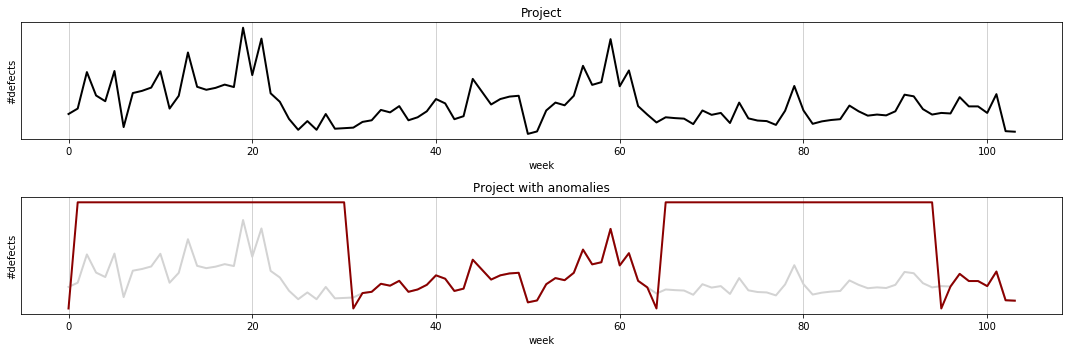

In [9]:
plot_sequence_with_anomalies(project_a_seq, project_a_anomaly_seq)

In [10]:
project_b_gt = inject_rectangular_anomalies(window, project_b_anomaly_seq)

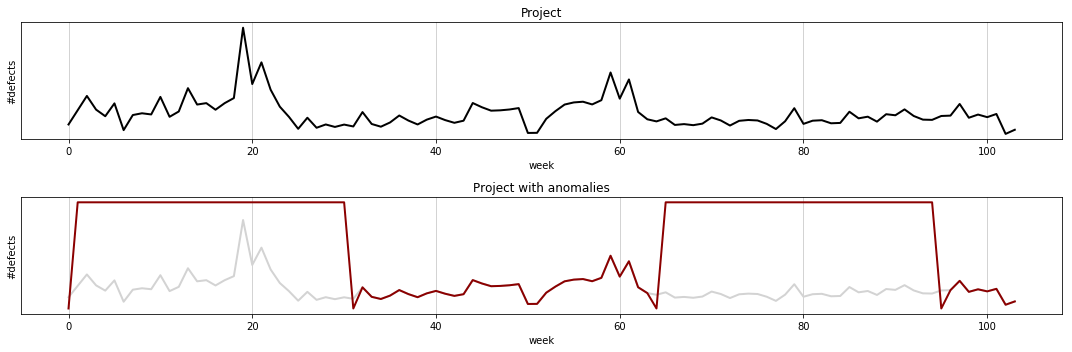

In [11]:
plot_sequence_with_anomalies(project_b_seq, project_b_anomaly_seq)

## 3. Run the simulation

In [12]:
# parameters
windows = [window]
within_min_dists = [1]
nbinses = [x for x in range(2, window + 1)]
alphabets = [x for x in range(3, 21)]
strides = [1]
score_thresholds = [1]

params = list(itertools.product(*[windows, within_min_dists, nbinses, alphabets, score_thresholds, strides]))

In [13]:
output_folder = "./data-examples/simulation/"

In [14]:
# project a
project_sequences = [project_a_anomaly_seq, project_a_seq]
sim_a_filename = simulate_alignments(params, project_sequences, output_folder=output_folder, 
                        check_50_50_criterion=False, ignore_list=project_a_gt)


32 2 3 1 1.0 1.0
32 2 4 1 0.9903846153846154 1.0
32 2 5 1 1.0 1.0
32 2 6 1 0.9903846153846154 1.0
32 2 7 1 1.0 1.0
32 2 8 1 0.9903846153846154 1.0
32 2 9 1 1.0 1.0
32 2 10 1 0.9903846153846154 1.0
32 2 11 1 1.0 1.0
32 2 12 1 0.9903846153846154 1.0
32 2 13 1 1.0 1.0
32 2 14 1 0.9903846153846154 1.0
32 2 15 1 1.0 1.0
32 2 16 1 0.9903846153846154 1.0
32 2 17 1 1.0 1.0
32 2 18 1 0.9903846153846154 1.0
32 2 19 1 1.0 1.0
32 2 20 1 0.9903846153846154 1.0
32 3 3 1 0.9615384615384616 0.9423076923076923
32 3 4 1 1.0 0.9615384615384616
32 3 5 1 0.9903846153846154 0.9615384615384616
32 3 6 1 0.9615384615384616 0.9230769230769231
32 3 7 1 0.9711538461538461 0.9326923076923077
32 3 8 1 0.9903846153846154 0.9230769230769231
32 3 9 1 0.9615384615384616 0.9230769230769231
32 3 10 1 0.9423076923076923 0.9230769230769231
32 3 11 1 0.9519230769230769 0.9230769230769231
32 3 12 1 0.9326923076923077 0.9038461538461539
32 3 13 1 0.9423076923076923 0.875
32 3 14 1 0.9230769230769231 0.8557692307692307
32 3 15

32 12 5 1 0.3173076923076923 0.3173076923076923
32 12 6 1 0.3076923076923077 0.3076923076923077
32 12 7 1 0.3076923076923077 0.3076923076923077
32 12 8 1 0.3076923076923077 0.3076923076923077
32 12 9 1 0.3076923076923077 0.3076923076923077
32 12 10 1 0.3173076923076923 0.3173076923076923
32 12 11 1 0.3076923076923077 0.3076923076923077
32 12 12 1 0.3076923076923077 0.3076923076923077
32 12 13 1 0.3173076923076923 0.3173076923076923
32 12 14 1 0.3076923076923077 0.3076923076923077
32 12 15 1 0.3076923076923077 0.3076923076923077
32 12 16 1 0.3076923076923077 0.3076923076923077
32 12 17 1 0.3076923076923077 0.3076923076923077
32 12 18 1 0.3076923076923077 0.3076923076923077
32 12 19 1 0.3076923076923077 0.3076923076923077
32 12 20 1 0.3076923076923077 0.3076923076923077
32 13 3 1 0.3173076923076923 0.3173076923076923
32 13 4 1 0.3269230769230769 0.3269230769230769
32 13 5 1 0.3173076923076923 0.3173076923076923
32 13 6 1 0.3076923076923077 0.3076923076923077
32 13 7 1 0.3076923076923077 

32 21 12 1 0.3076923076923077 0.3076923076923077
32 21 13 1 0.3076923076923077 0.3076923076923077
32 21 14 1 0.3076923076923077 0.3076923076923077
32 21 15 1 0.3076923076923077 0.3076923076923077
32 21 16 1 0.3076923076923077 0.3076923076923077
32 21 17 1 0.3076923076923077 0.3076923076923077
32 21 18 1 0.3076923076923077 0.3076923076923077
32 21 19 1 0.3076923076923077 0.3076923076923077
32 21 20 1 0.3076923076923077 0.3076923076923077
32 22 3 1 0.3173076923076923 0.3173076923076923
32 22 4 1 0.3173076923076923 0.3173076923076923
32 22 5 1 0.3076923076923077 0.3076923076923077
32 22 6 1 0.3076923076923077 0.3076923076923077
32 22 7 1 0.3076923076923077 0.3076923076923077
32 22 8 1 0.3076923076923077 0.3076923076923077
32 22 9 1 0.3076923076923077 0.3076923076923077
32 22 10 1 0.3076923076923077 0.3076923076923077
32 22 11 1 0.3076923076923077 0.3076923076923077
32 22 12 1 0.3076923076923077 0.3076923076923077
32 22 13 1 0.3076923076923077 0.3076923076923077
32 22 14 1 0.30769230769230

32 30 19 1 0.3076923076923077 0.3076923076923077
32 30 20 1 0.3076923076923077 0.3076923076923077
32 31 3 1 0.3173076923076923 0.3173076923076923
32 31 4 1 0.3076923076923077 0.3076923076923077
32 31 5 1 0.3076923076923077 0.3076923076923077
32 31 6 1 0.3076923076923077 0.3076923076923077
32 31 7 1 0.3173076923076923 0.3173076923076923
32 31 8 1 0.3076923076923077 0.3076923076923077
32 31 9 1 0.3076923076923077 0.3076923076923077
32 31 10 1 0.3076923076923077 0.3076923076923077
32 31 11 1 0.3076923076923077 0.3076923076923077
32 31 12 1 0.3076923076923077 0.3076923076923077
32 31 13 1 0.3076923076923077 0.3076923076923077
32 31 14 1 0.3076923076923077 0.3076923076923077
32 31 15 1 0.3076923076923077 0.3076923076923077
32 31 16 1 0.3076923076923077 0.3076923076923077
32 31 17 1 0.3076923076923077 0.3076923076923077
32 31 18 1 0.3076923076923077 0.3076923076923077
32 31 19 1 0.3076923076923077 0.3076923076923077
32 31 20 1 0.3076923076923077 0.3076923076923077
32 32 3 1 0.307692307692307

In [15]:
sim_a_filename

'sim_2019_05_3_13255.xlsx'

In [16]:
# project b
project_sequences = [project_b_anomaly_seq, project_b_seq]
sim_b_filename = simulate_alignments(params, project_sequences, output_folder=output_folder, 
                        check_50_50_criterion=False, ignore_list=project_b_gt)


32 2 3 1 1.0 1.0
32 2 4 1 0.9903846153846154 1.0
32 2 5 1 1.0 1.0
32 2 6 1 0.9903846153846154 1.0
32 2 7 1 1.0 1.0
32 2 8 1 0.9903846153846154 1.0
32 2 9 1 1.0 1.0
32 2 10 1 0.9903846153846154 1.0
32 2 11 1 1.0 1.0
32 2 12 1 0.9903846153846154 1.0
32 2 13 1 1.0 1.0
32 2 14 1 0.9903846153846154 1.0
32 2 15 1 1.0 1.0
32 2 16 1 0.9903846153846154 1.0
32 2 17 1 1.0 1.0
32 2 18 1 0.9903846153846154 1.0
32 2 19 1 1.0 1.0
32 2 20 1 0.9903846153846154 0.9615384615384616
32 3 3 1 0.9615384615384616 0.9134615384615384
32 3 4 1 0.9423076923076923 1.0
32 3 5 1 0.9230769230769231 0.875
32 3 6 1 0.9615384615384616 0.875
32 3 7 1 0.7019230769230769 0.8846153846153846
32 3 8 1 0.6923076923076923 0.8942307692307693
32 3 9 1 0.9423076923076923 0.875
32 3 10 1 0.9230769230769231 0.875
32 3 11 1 0.9230769230769231 0.875
32 3 12 1 0.4807692307692308 0.8653846153846154
32 3 13 1 0.46153846153846156 0.8365384615384616
32 3 14 1 0.7019230769230769 0.875
32 3 15 1 0.9230769230769231 0.8557692307692307
32 3 16 

32 12 6 1 0.3173076923076923 0.3173076923076923
32 12 7 1 0.3173076923076923 0.3173076923076923
32 12 8 1 0.3076923076923077 0.3076923076923077
32 12 9 1 0.3076923076923077 0.3076923076923077
32 12 10 1 0.3076923076923077 0.3076923076923077
32 12 11 1 0.3076923076923077 0.3076923076923077
32 12 12 1 0.3076923076923077 0.3076923076923077
32 12 13 1 0.3076923076923077 0.3076923076923077
32 12 14 1 0.3076923076923077 0.3076923076923077
32 12 15 1 0.3076923076923077 0.3076923076923077
32 12 16 1 0.3076923076923077 0.3076923076923077
32 12 17 1 0.3076923076923077 0.3076923076923077
32 12 18 1 0.3076923076923077 0.3076923076923077
32 12 19 1 0.3076923076923077 0.3076923076923077
32 12 20 1 0.3076923076923077 0.3076923076923077
32 13 3 1 0.3269230769230769 0.3269230769230769
32 13 4 1 0.3076923076923077 0.3076923076923077
32 13 5 1 0.3076923076923077 0.3076923076923077
32 13 6 1 0.3173076923076923 0.3173076923076923
32 13 7 1 0.3076923076923077 0.3076923076923077
32 13 8 1 0.3076923076923077 

32 21 13 1 0.3076923076923077 0.3076923076923077
32 21 14 1 0.3076923076923077 0.3076923076923077
32 21 15 1 0.3076923076923077 0.3076923076923077
32 21 16 1 0.3076923076923077 0.3076923076923077
32 21 17 1 0.3076923076923077 0.3076923076923077
32 21 18 1 0.3076923076923077 0.3076923076923077
32 21 19 1 0.3076923076923077 0.3076923076923077
32 21 20 1 0.3076923076923077 0.3076923076923077
32 22 3 1 0.3076923076923077 0.3076923076923077
32 22 4 1 0.3076923076923077 0.3076923076923077
32 22 5 1 0.3076923076923077 0.3076923076923077
32 22 6 1 0.3076923076923077 0.3076923076923077
32 22 7 1 0.3076923076923077 0.3076923076923077
32 22 8 1 0.3076923076923077 0.3076923076923077
32 22 9 1 0.3076923076923077 0.3076923076923077
32 22 10 1 0.3076923076923077 0.3076923076923077
32 22 11 1 0.3076923076923077 0.3076923076923077
32 22 12 1 0.3076923076923077 0.3076923076923077
32 22 13 1 0.3076923076923077 0.3076923076923077
32 22 14 1 0.3076923076923077 0.3076923076923077
32 22 15 1 0.30769230769230

32 30 20 1 0.3076923076923077 0.3076923076923077
32 31 3 1 0.3173076923076923 0.3173076923076923
32 31 4 1 0.3076923076923077 0.3076923076923077
32 31 5 1 0.3076923076923077 0.3076923076923077
32 31 6 1 0.3076923076923077 0.3076923076923077
32 31 7 1 0.3076923076923077 0.3076923076923077
32 31 8 1 0.3076923076923077 0.3076923076923077
32 31 9 1 0.3076923076923077 0.3076923076923077
32 31 10 1 0.3076923076923077 0.3076923076923077
32 31 11 1 0.3076923076923077 0.3076923076923077
32 31 12 1 0.3076923076923077 0.3076923076923077
32 31 13 1 0.3076923076923077 0.3076923076923077
32 31 14 1 0.3076923076923077 0.3076923076923077
32 31 15 1 0.3076923076923077 0.3076923076923077
32 31 16 1 0.3076923076923077 0.3076923076923077
32 31 17 1 0.3076923076923077 0.3076923076923077
32 31 18 1 0.3076923076923077 0.3076923076923077
32 31 19 1 0.3076923076923077 0.3076923076923077
32 31 20 1 0.3076923076923077 0.3076923076923077
32 32 3 1 0.3173076923076923 0.3173076923076923
32 32 4 1 0.3269230769230769

In [17]:
sim_b_filename

'sim_2019_05_3_135249.xlsx'

## 4. Load results and interpret them

Normally, we would load the *sim_a_filename* and *sim_b_filename* files, but since the names are autogenerated, we will use two files that we know of and are stored in the "./data-examples" folder.

In [2]:
simulation_data = pd.concat([pd.read_excel("./data-examples/simulation/sim_2019_05_3_13255.xlsx"),
                     pd.read_excel("./data-examples/simulation/sim_2019_05_3_135249.xlsx")], axis=0)
simulation_data.drop(['Unnamed: 12', 'Unnamed: 13'], inplace=True, axis=1)

In [3]:
simulation_data.head(2)

,project_a,project_b,window,nbins,alphabet,score_threshold,within_min_dist,stride,coverage_a,coverage_b,coverage_avg,50_50_criterion,accuracy,fscore,precision,recall
0,Anomaly_eclipse_jdt_,eclipse_jdt_sample_b,32,2,3,1,1,1,1.000000,1.0,1.000000,1,0.384615,0.555556,0.384615,1.0
1,Anomaly_eclipse_jdt_,eclipse_jdt_sample_b,32,2,4,1,1,1,0.990385,1.0,0.995192,1,0.394231,0.559441,0.388350,1.0


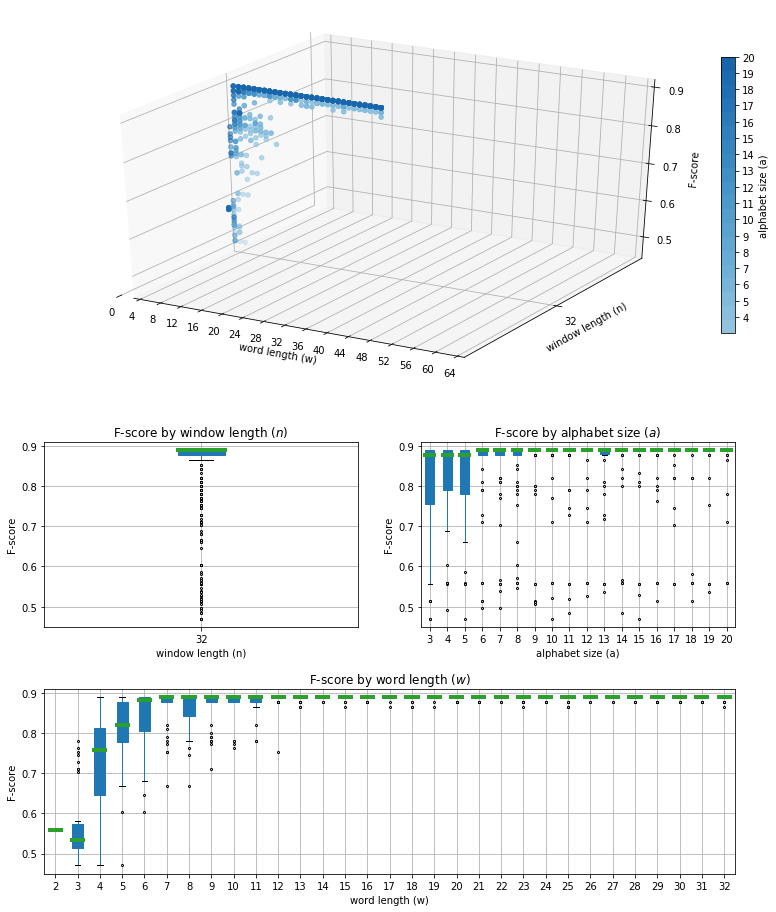

In [4]:
plot_simulation_3d(simulation_data)

From the plot above, we can see that the maximum F-score is reached for w = 7 and a = 7, also variability of F-score for these values of parameters is getting smaller. Of course, from this plot, we can't see the combinations between both w and a. We need to explore it further.

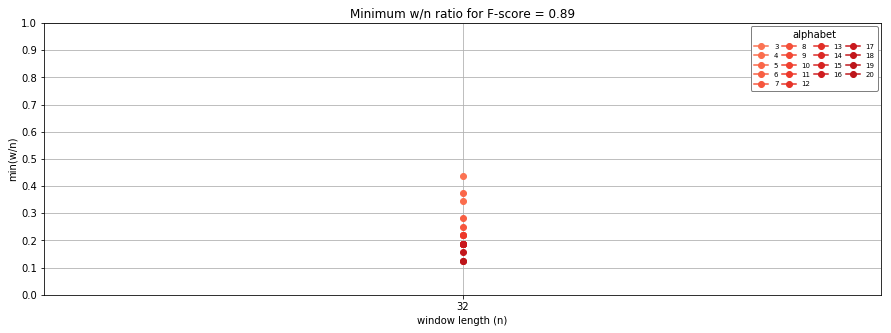

In [5]:
plot_simulation_word_vs_w_to_n(simulation_data)

Let's assume we would like to stay with w = 7, let's see what values of a would be feasible to achieve max F-score.

In [12]:
max_fscore = simulation_data['fscore'].astype('float32').max()
simulation_data[(simulation_data['fscore'].astype('float32') == max_fscore) & (simulation_data['nbins'] == 7)].sort_values('alphabet').head(1)

,project_a,project_b,window,nbins,alphabet,score_threshold,within_min_dist,stride,coverage_a,coverage_b,coverage_avg,50_50_criterion,accuracy,fscore,precision,recall
95,Anomaly_eclipse_plat,eclipse_platform_sam,32,7,8,1,1,1,0.307692,0.307692,0.307692,0,0.923077,0.888889,1.0,0.8


We can conclude that one of the reasonable configurations would be to have n=32, w=7, a=8